# SCOG Trip Generation

## Household Travel Survey Estimation Dataset

michael.mccarthy@rsginc.com


In [1]:
# setup
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import openmatrix as omx


In [2]:
def freqPlot(df, var, query=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

    if query != None:
        data = df.query(query)
    else: 
        data = df
    
    counts = data[var].value_counts()
    axes.bar(counts.index, counts.values)
    axes.set_title(var)
    axes.set_xlabel(var)
    axes.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# from Bishoy
def GetTripRatesUsingOneVars(hh_df, trips_df, x, groups, cat, *args, **kwargs):
    """
    Calculate trip rates per cross-classified hhh
    
    Parameters:
    HTS_df: trip records joined to hh + persons
    x: x-class variable no. 1

    groups: trip purpose, i.e., hbs, hbw, ... etc.!
    cat: usually triprate (continous variable), but if trip, we will report the absolute number of trips (discrete)
    """
    HH_PivotTable = hh_df.groupby([x])['hh_weight'].sum().reset_index()
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    # Finally, pivot the trips using the defined x and y by summing up the trip_weight
    Trip_PivotTable = trips_df.groupby([x])['trip_weight'].sum().reset_index()
    
    if cat == "trip":
        result_table=pd.merge(HH_PivotTable, Trip_PivotTable, left_on=x, right_on=x, how='inner')

    else:
        result_table=pd.merge(HH_PivotTable, Trip_PivotTable, left_on=x, right_on=x, how='inner')
        result_table['trips_rate'] = result_table['trip_weight']/result_table['hh_weight']
    result_table=result_table.fillna(0)
        
    return result_table

def GetTripRatesUsingTwoVars(hh_df, trips_df, x, y, groups, cat, *args, **kwargs):
    """
    Calculate trip rates per cross-classified hhh
    
    Parameters:
    HTS_df: trip records joined to hh + persons
    x: x-class variable no. 1
    y: x-class variable no. 2, if any!
    groups: trip purpose, i.e., hbs, hbw, ... etc.!
    cat: usually triprate (continous variable), but if trip, we will report the absolute number of trips (discrete)
    """
   
    HH_PivotTable = pd.pivot_table(hh_df, values="hh_weight", index=[y],
                        columns=[x], aggfunc=np.sum)     # population
    # Filter out the specific trip purpose: ['nhb', 'hbo', 'hbr', 'hbw', 'hbsc', 'hbc']
    if groups != "all":
        trips_df = trips_df[trips_df["model_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    # Finally, pivot the trips using the defined x and y by summing up the trip_weight
    dta = "trip_weight"
    Trip_PivotTable = pd.pivot_table(trips_df, values=dta, index=[y],
                    columns=[x], aggfunc=np.sum)     # population

    if cat == "trip":
        result_table = Trip_PivotTable
    else:
        result_table = Trip_PivotTable/HH_PivotTable    # get the rates by dividing by the number of hh's in the respective market segment
    result_table=result_table.fillna(0)
    return result_table

def GetTripRatesUsingOneVars_Unweighted(hh_df, trips_df, x, groups, cat, *args, **kwargs):
    """
    Calculate trip rates per cross-classified hhh
    
    Parameters:
    HTS_df: trip records joined to hh + persons
    x: x-class variable no. 1

    groups: trip purpose, i.e., hbs, hbw, ... etc.!
    cat: usually triprate (continous variable), but if trip, we will report the absolute number of trips (discrete)
    """
    HH_PivotTable = hh_df.groupby([x])['hh_id'].count().reset_index()
    if groups != "all":
        trips_df = trips_df[trips_df["trip_purpose"] == groups].copy()
    else:
        trips_df = trips_df.copy()

    # Finally, pivot the trips using the defined x and y by summing up the trip_weight
    Trip_PivotTable = trips_df.groupby([x])['trip_id'].count().reset_index()
    
    if cat == "trip":
        result_table=pd.merge(HH_PivotTable, Trip_PivotTable, left_on=x, right_on=x, how='inner')

    else:
        result_table=pd.merge(HH_PivotTable, Trip_PivotTable, left_on=x, right_on=x, how='inner')
        result_table['trips_rate'] = result_table['trip_id']/result_table['hh_id']
    result_table=result_table.fillna(0)
        
    return result_table

def tripQA(trips_df, lookup_pairs, qa_queries):
    """
        Method for decoding survey codes (trip purpose and mode) and run queries (check reported trip duration/speed) and export sample for QA 

        Parameters:
        trips_df: trips dataframe
        decode: dict of column, lookup pairs, such as {"o_purpose_category": purpose_lookup_dict}
            queries use numexpr, column names and operators passsed in one string, such as
            df.eval("(mode_type == 1 & speed_mph > 4) | (mode_type == 2 & speed_mph > 20) | (speed_mph > 70)"

    """

    for dfcol, lookup in lookup_pairs.items():
        trips_df[dfcol+"_decode"] = trips_df[dfcol].map(lookup)

    for dfcol, query in qa_queries.items():
        trips_df[dfcol+"_QA"] = trips_df.eval(query) # return True/False column

    return trips_df

In [3]:
# read in survey tables: households and trips

trips = pd.read_csv('data/trip.csv')
hh = pd.read_csv('data/hh.csv')
person = pd.read_csv('data/person.csv')

In [4]:
#Get specific variables for HH characteristics
hh["hh_size"] = np.where(hh["num_people"]>=4, 4, hh["num_people"])
hh["w_size"] = np.where(hh["num_workers"]>=3, 3, hh["num_workers"])

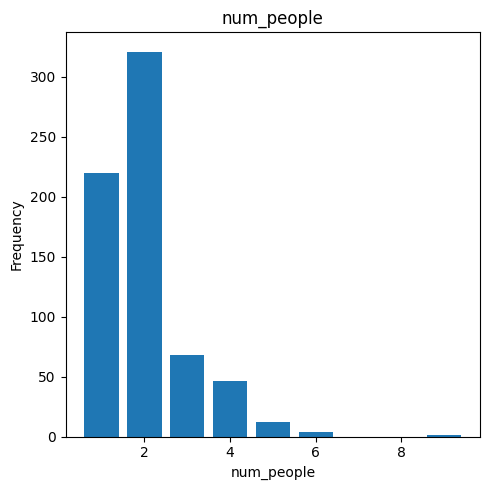

In [5]:
freqPlot(hh,'num_people')

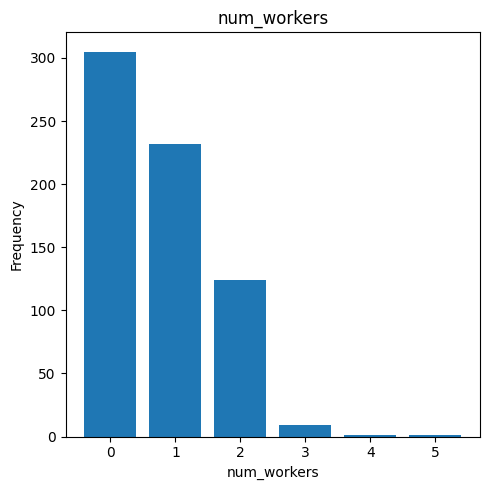

In [6]:
freqPlot(hh,'num_workers')

In [7]:
# TAZ income category: INC1 < 25k; INC2 25-50k; INC3 50-75k; INC4 >75k
# income_broad	1	Under $25,000
# income_broad	2	$25,000-$49,999
# income_broad	3	$50,000-$74,999
# income_broad	4	$75,000-$99,999
# income_broad	5	$100,000-$199,999
# income_broad	6	$200,000 or more
# income_broad	999	Prefer not to answer


income_cat = [
    (hh['income_broad'] == 999),
    (hh['income_broad'] == 1),
    (hh['income_broad'] == 2),
    (hh['income_broad'] == 3),
    (hh['income_broad'] >= 4)
]
income_cat_labels = ['NR','INC1','INC2','INC3','INC4'] # using NR for no response
hh["hh_inc"] = np.select(income_cat, income_cat_labels, default='NR')

hh["hh_inc"].unique()

array(['INC3', 'NR', 'INC2', 'INC1', 'INC4'], dtype=object)

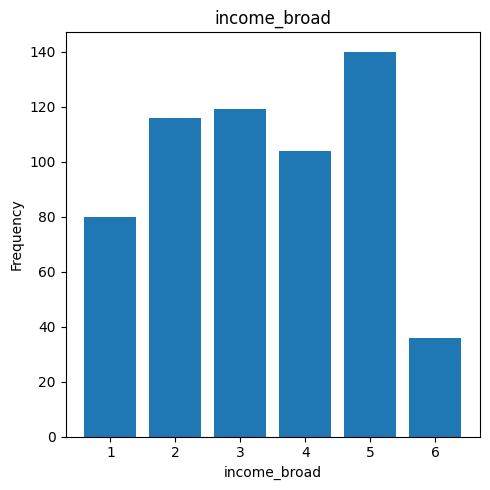

In [8]:
freqPlot(hh,'income_broad','income_broad <= 6')

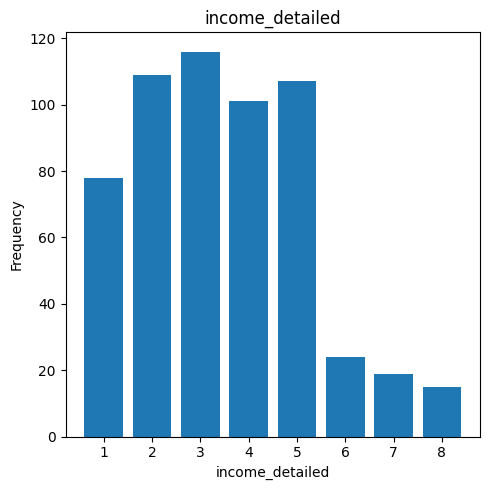

In [9]:
freqPlot(hh,'income_detailed','income_detailed <= 8')

In [10]:
hh[(hh['income_broad'] == 999)]

,bicycle_type_electric,bicycle_type_other,bicycle_type_standard,bike_store_garage,bike_store_house,bike_store_locker,bike_store_other,bike_store_other_object,bike_store_rack,bike_store_secured_room,...,num_workers,participation_group,residence_rent_own,residence_type,sample_home_bg,sample_segment,hh_weight,hh_size,w_size,hh_inc
1,1,0,0,0,1,0,0,0,0,0,...,0,1,1,1,530579402002,1,13.062519,2,0,NR
2,995,995,995,995,995,995,995,995,995,995,...,0,1,999,1,530579403002,1,19.533518,2,0,NR
10,0,0,1,0,1,0,0,0,0,0,...,2,1,1,1,530579516003,1,86.582026,3,2,NR
14,995,995,995,995,995,995,995,995,995,995,...,2,3,1,1,530579524011,2,55.544301,2,2,NR
21,0,0,1,0,1,0,0,0,0,0,...,0,1,1,1,530579403003,1,19.294569,2,0,NR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,0,0,1,0,1,0,0,0,0,0,...,0,1,1,1,530579508001,2,15.365910,1,0,NR
628,995,995,995,995,995,995,995,995,995,995,...,0,1,1,1,530579511004,1,23.661309,2,0,NR
636,995,995,995,995,995,995,995,995,995,995,...,0,1,1,1,530579524011,2,9.316400,2,0,NR
651,995,995,995,995,995,995,995,995,995,995,...,0,1,1,1,530579524023,1,19.981104,1,0,NR


In [11]:
# 26 HHs provided broad income, but not detailed 
hh.loc[((hh['income_broad'] == 999) | (hh['income_detailed'] == 999)) & (hh['income_broad'] != hh['income_detailed']), ['income_broad','income_detailed']]

,income_broad,income_detailed
80,2,999
94,2,999
118,4,999
121,2,999
130,6,999
135,2,999
140,5,999
143,5,999
179,3,999
209,3,999


In [12]:
# no imputed income for prefer not to answer
hh.columns

Index(['bicycle_type_electric', 'bicycle_type_other', 'bicycle_type_standard',
       'bike_store_garage', 'bike_store_house', 'bike_store_locker',
       'bike_store_other', 'bike_store_other_object', 'bike_store_rack',
       'bike_store_secured_room', 'bike_store_unlocked', 'complete_fri',
       'complete_mon', 'complete_sat', 'complete_sun', 'complete_thu',
       'complete_tue', 'complete_wed', 'first_travel_date', 'hh_id', 'home_bg',
       'home_lat', 'home_lon', 'home_park', 'home_park_pay', 'home_zone',
       'home_county', 'income_broad', 'income_detailed', 'last_travel_date',
       'micromobility_devices_moped', 'micromobility_devices_none',
       'micromobility_devices_other', 'micromobility_devices_scooter',
       'micromobility_devices_skateboard', 'num_adults', 'num_bicycles',
       'num_days_complete', 'num_people', 'num_surveyable_people',
       'num_vehicles', 'num_workers', 'participation_group',
       'residence_rent_own', 'residence_type', 'sample_home_bg',

In [13]:
impute_hh = hh[(hh['income_broad'] == 999)]
impute_hh_weight = impute_hh['hh_weight'].sum()
impute_hh_weight_pct = impute_hh['hh_weight'].sum() / hh['hh_weight'].sum()

print(f"{len(impute_hh)} of {len(hh)} surveyed households did not provide income. This represents {impute_hh_weight:.2f} weighted households or {impute_hh_weight_pct:.2%} of the total HH weight.")

77 of 672 surveyed households did not provide income. This represents 3849.49 weighted households or 7.94% of the total HH weight.


## Trip Purposes

In [14]:
trips.columns

Index(['arrive_date', 'arrive_dow', 'arrive_hour', 'arrive_minute',
       'arrive_second', 'bike_park_location', 'd_bg', 'd_county',
       'd_in_region', 'd_lat', 'd_lon', 'd_purpose', 'd_purpose_category',
       'd_zone', 'depart_date', 'depart_dow', 'depart_hour', 'depart_minute',
       'depart_second', 'distance_miles', 'driver', 'duration_minutes',
       'ev_charge_station', 'ev_charge_station_decision',
       'ev_charge_station_level_1', 'ev_charge_station_level_2',
       'ev_charge_station_level_3', 'ev_charge_station_level_dk',
       'google_alighting_station', 'google_boarding_station', 'hh_member_1',
       'hh_member_2', 'hh_member_3', 'hh_member_4', 'hh_member_5',
       'hh_member_6', 'hh_member_7', 'hh_member_8', 'hh_member_9', 'leg_num',
       'mode_1', 'mode_2', 'mode_3', 'mode_4', 'mode_other_specify',
       'mode_type', 'num_hh_travelers', 'num_non_hh_travelers',
       'num_travelers', 'o_bg', 'o_county', 'o_in_region', 'o_lat', 'o_lon',
       'o_purpose', 

In [15]:
# get lists of purposes by category
o_purp_cat = trips.groupby(['o_purpose_category', 'o_purpose']).size().reset_index().rename(columns={0:'count'})
d_purp_cat = trips.groupby(['d_purpose_category', 'd_purpose']).size().reset_index().rename(columns={0:'count'})

In [16]:
purp_cat = [
    ((trips['o_purpose'] == 1) & (trips['d_purpose'] == 1)), # Loop trip home to home
    ((trips['o_purpose'] == 151) | (trips['d_purpose'] == 151)), # Loop trip (split by analyst)
    ((trips['o_purpose_category'] == 1) & (trips['d_purpose_category'].isin([2,3]))), # HBW PA trip
    ((trips['o_purpose_category'].isin([2,3])) & (trips['d_purpose_category'] == 1)), # HBW AP trip
    ((trips['o_purpose_category'] == 1) & ~(trips['d_purpose_category'].isin([2,3]))), # HBO PA trip
    (~(trips['o_purpose_category'].isin([2,3])) & (trips['d_purpose_category'] == 1)), # HBO AP trip
    ((trips['o_purpose_category'].isin([2,3])) | (trips['d_purpose_category'].isin([2,3]))), # NHBW trip
    (~(trips['o_purpose_category'].isin([2,3])) & ~(trips['d_purpose_category'].isin([2,3]))), # NHBO trip
    True
]
# evaluates to first true condition
purp_cat_labels = ['Loop','Loop','HBW','HBW','HBO','HBO','NHBW','NHBO','NA']
trips['model_purpose'] = np.select(purp_cat, purp_cat_labels, default='NA')

In [17]:
trips['model_purpose'].value_counts()

model_purpose
HBO     6979
NHBO    4807
NHBW    1630
HBW     1204
Loop      37
Name: count, dtype: int64

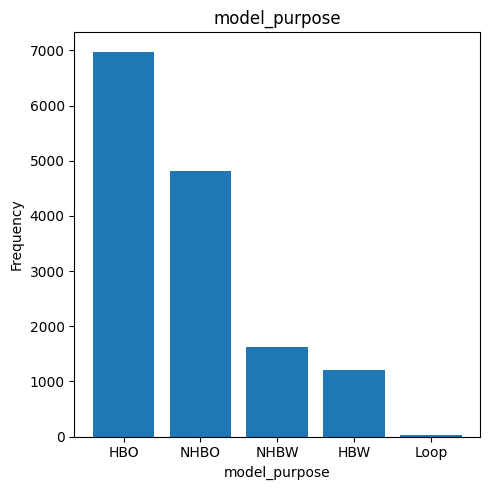

In [18]:
freqPlot(trips,'model_purpose')

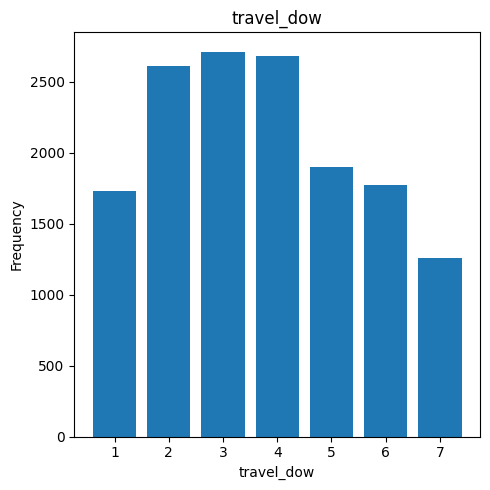

In [19]:
freqPlot(trips,'travel_dow')

In [20]:
# internal/external segments
# we are generating external trips separately, so consider internal-internal trips for generation rates

trips['market_segment'] = ''
trips.loc[(trips['o_in_region'] == 1) & (trips['d_in_region'] == 1), 'market_segment'] = 'II'
trips.loc[(trips['o_in_region'] == 0) & (trips['d_in_region'] == 1), 'market_segment'] = 'XI'
trips.loc[(trips['o_in_region'] == 1) & (trips['d_in_region'] == 0), 'market_segment'] = 'IX'
trips.loc[(trips['o_in_region'] == 0) & (trips['d_in_region'] == 0), 'market_segment'] = 'XX'

# question of what is "in region"



In [21]:
# trips by market segment and day of week
markettab = trips.pivot_table(index='market_segment',columns='travel_dow',values='trip_weight', aggfunc='sum')
markettab

# markettab.to_clipboard()

travel_dow,1,2,3,4,5,6,7
market_segment,,,,,,,
II,0.0,118149.313949,106209.892332,101222.416258,0.0,0.0,0.0
IX,0.0,8944.009379,5041.469412,9208.515118,0.0,0.0,0.0
XI,0.0,9756.875213,4756.799517,8799.881640,0.0,0.0,0.0
XX,0.0,10254.578006,11002.883704,12550.568244,0.0,0.0,0.0


In [22]:
valid_trips = trips[(trips['market_segment']=='II') & (trips['travel_dow'].isin([2, 3, 4])) & (trips['trip_weight'] > 0)]

In [23]:
# label mode
mode_lookup = {
    1: "Walk",
    2: "Bicycle or e-bicycle",
    3: "Bike-share",
    4: "Scooter-share",
    5: "Taxi",
    6: "Smartphone-app ridehailing service",
    7: "Other",
    8: "Vehicle",
    9: "Carshare",
    10: "School bus",
    11: "Shuttle",
    12: "Ferry",
    13: "Transit",
    14: "Long distance passenger mode",
    995: "Missing: Not required (e.g., analyst unlinked trip)",
    -9998:	"Missing: Did not provide a response",
    -9999:	"Missing: Technical error"
}

valid_trips['mode_label'] = valid_trips['mode_type'].map(mode_lookup)


C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_26276\675091396.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_trips['mode_label'] = valid_trips['mode_type'].map(mode_lookup)


In [24]:
# And only hh with hh_id in the accounted for trips should be considered
valid_hh = hh[hh['hh_id'].isin(valid_trips['hh_id'].unique())]
len(valid_hh)

535

In [25]:
# Join HH categories to trips
trip_join = valid_trips.merge(valid_hh, right_on="hh_id", left_on="hh_id", how="left")

In [26]:
# reclassify HBW trips made by zero-worker HHs
# NHBW as well (SRTC lacks NHBW/O purposes)
trip_join.loc[((trip_join['w_size'] == 0) & (trip_join['model_purpose'] == 'HBW')), "model_purpose"] = 'HBO'
trip_join.loc[((trip_join['w_size'] == 0) & (trip_join['model_purpose'] == 'NHBW')), "model_purpose"] = 'NHBO'

In [27]:
# identify persons reporting they are unemployed or volunteers
# reclassify HBW as HBO as well
unemployed = person[person['employment'].isin([6,7])]
trip_join.loc[((trip_join['person_id'].isin(unemployed['person_id'])) & (trip_join['model_purpose'] == 'HBW')), "model_purpose"] = 'HBO'
trip_join.loc[((trip_join['person_id'].isin(unemployed['person_id'])) & (trip_join['model_purpose'] == 'NHBW')), "model_purpose"] = 'NHBO'

In [28]:

# export dataset
trip_join.to_csv('SCOG_HTS_trips.csv')
valid_hh.to_csv('SCOG_HTS_hh.csv')

## QA and Reasonability checks

In [29]:
# missing income
inc_qa = valid_hh[(valid_hh['income_broad'] == 999)]
inc_qa

,bicycle_type_electric,bicycle_type_other,bicycle_type_standard,bike_store_garage,bike_store_house,bike_store_locker,bike_store_other,bike_store_other_object,bike_store_rack,bike_store_secured_room,...,num_workers,participation_group,residence_rent_own,residence_type,sample_home_bg,sample_segment,hh_weight,hh_size,w_size,hh_inc
10,0,0,1,0,1,0,0,0,0,0,...,2,1,1,1,530579516003,1,86.582026,3,2,NR
14,995,995,995,995,995,995,995,995,995,995,...,2,3,1,1,530579524011,2,55.544301,2,2,NR
21,0,0,1,0,1,0,0,0,0,0,...,0,1,1,1,530579403003,1,19.294569,2,0,NR
28,0,0,1,0,1,0,0,0,0,0,...,1,2,1,3,530579515004,2,8.585023,1,1,NR
31,0,0,1,0,1,0,0,0,0,0,...,0,4,2,4,530579402001,1,53.735204,2,0,NR
33,0,0,1,0,1,0,0,0,0,0,...,1,1,1,1,530579403003,1,34.726506,2,1,NR
38,0,0,1,0,1,0,0,0,0,0,...,1,4,1,2,530579515003,2,45.189102,1,1,NR
44,0,0,1,0,1,0,0,0,0,0,...,1,1,1,1,530579408001,2,28.634716,1,1,NR
54,995,995,995,995,995,995,995,995,995,995,...,0,1,2,6,530579522001,2,35.733777,1,0,NR
65,995,995,995,995,995,995,995,995,995,995,...,0,1,1,1,530579524023,1,21.013339,1,0,NR


In [30]:
inc_qa['hh_weight'].sum()

np.float64(3150.821998947439)

In [49]:
# trips made by HH missing income
inc_qa_trips = trip_join[trip_join['hh_id'].isin(inc_qa['hh_id'].unique())]
inc_qa_trips

,arrive_date,arrive_dow,arrive_hour,arrive_minute,arrive_second,bike_park_location,d_bg,d_county,d_in_region,d_lat,...,num_workers,participation_group,residence_rent_own,residence_type,sample_home_bg,sample_segment,hh_weight,hh_size,w_size,hh_inc
78,2021-10-27,3,7,55,0,995,5.305795e+11,53057.0,1,48.47708,...,2,1,1,1,530579516003,1,86.582026,3,2,NR
79,2021-10-27,3,10,45,0,995,5.305795e+11,53057.0,1,48.45638,...,2,1,1,1,530579516003,1,86.582026,3,2,NR
80,2021-10-27,3,20,25,0,995,5.305795e+11,53057.0,1,48.45120,...,2,1,1,1,530579516003,1,86.582026,3,2,NR
81,2021-10-27,3,7,55,0,995,5.305795e+11,53057.0,1,48.47708,...,2,1,1,1,530579516003,1,86.582026,3,2,NR
82,2021-10-27,3,18,30,0,995,5.305795e+11,53057.0,1,48.51079,...,2,1,1,1,530579516003,1,86.582026,3,2,NR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5521,2021-10-19,2,13,15,0,995,5.305795e+11,53057.0,1,48.52944,...,0,1,1,1,530579511004,1,27.915906,2,0,NR
5522,2021-10-19,2,13,35,0,995,5.305795e+11,53057.0,1,48.49031,...,0,1,1,1,530579511004,1,27.915906,2,0,NR
5523,2021-10-19,2,17,25,0,995,5.305795e+11,53057.0,1,48.54267,...,0,1,1,1,530579511004,1,27.915906,2,0,NR
5524,2021-10-19,2,19,10,0,995,5.305795e+11,53057.0,1,48.53792,...,0,1,1,1,530579511004,1,27.915906,2,0,NR


In [50]:
inc_qa_trips['trip_weight'].sum()

np.float64(27306.23733443788)

In [31]:
# check HH sample/weights
wgttrips = valid_trips[valid_trips['trip_weight'] > 0]

purpose_lookup = {
    1:	"Home",
    2:	"Work",
    3:	"Work related",
    4:	"School",
    5:	"School related",
    6:	"Escort",
    7:	"Shopping",
    8:	"Meal",
    9:	"Social/Recreation",
    10:	"Errand",
    11:	"Change mode",
    12:	"Overnight",
    997:	"Other",
    -9998:	"Missing: Did not provide a response"
}

mode_lookup = {
    1: "Walk",
    2: "Bicycle or e-bicycle",
    3: "Bike-share",
    4: "Scooter-share",
    5: "Taxi",
    6: "Smartphone-app ridehailing service",
    7: "Other",
    8: "Vehicle",
    9: "Carshare",
    10: "School bus",
    11: "Shuttle",
    12: "Ferry",
    13: "Transit",
    14: "Long distance passenger mode",
    995: "Missing: Not required (e.g., analyst unlinked trip)",
    -9998:	"Missing: Did not provide a response",
    -9999:	"Missing: Technical error"

}

qa_df = tripQA(wgttrips, lookup_pairs={"o_purpose_category": purpose_lookup, "d_purpose_category": purpose_lookup, "mode_type": mode_lookup}, qa_queries={'speed':'(mode_type == 1 & speed_mph > 4) | (mode_type == 2 & speed_mph > 20) | (speed_mph > 70)'})
qa_df = qa_df.sample(n=10)
qa_df

,arrive_date,arrive_dow,arrive_hour,arrive_minute,arrive_second,bike_park_location,d_bg,d_county,d_in_region,d_lat,...,person_num,hh_id,trip_weight,model_purpose,market_segment,mode_label,o_purpose_category_decode,d_purpose_category_decode,mode_type_decode,speed_QA
14444,2021-10-21,4,13,41,34,995,5.305795e+11,53057.0,1,48.45481,...,1,21029712,17.276615,HBO,II,Vehicle,Social/Recreation,Home,Vehicle,False
10606,2021-10-14,4,9,25,0,995,5.305795e+11,53057.0,1,48.44213,...,1,21022390,127.656050,HBO,II,Vehicle,Home,Shopping,Vehicle,False
11910,2021-11-02,2,19,12,3,995,5.305795e+11,53057.0,1,48.44118,...,2,21024221,37.721959,HBO,II,Vehicle,Other,Home,Vehicle,False
7878,2021-10-20,3,14,56,14,995,5.305795e+11,53057.0,1,48.47861,...,1,21016622,12.007170,HBO,II,Walk,Home,Social/Recreation,Walk,False
6496,2021-10-19,2,16,15,0,995,5.305794e+11,53057.0,1,48.48800,...,3,21012997,24.388245,HBO,II,Vehicle,School,Home,Vehicle,False
8576,2021-10-19,2,15,14,17,995,5.305795e+11,53057.0,1,48.41734,...,2,21018044,138.471742,NHBO,II,Walk,Social/Recreation,Social/Recreation,Walk,False
111,2021-10-19,2,7,9,9,995,5.305795e+11,53057.0,1,48.43752,...,3,21000012,11.683690,HBO,II,Vehicle,Home,Shopping,Vehicle,False
9012,2021-11-18,4,13,10,0,995,5.305795e+11,53057.0,1,48.43526,...,1,21018977,31.163833,NHBO,II,Vehicle,Shopping,Shopping,Vehicle,False
161,2021-10-20,3,16,3,3,995,5.305794e+11,53057.0,1,48.51266,...,1,21000567,34.786768,NHBO,II,Vehicle,Social/Recreation,Shopping,Vehicle,False
1109,2021-10-19,2,13,32,42,997,5.305795e+11,53057.0,1,48.56228,...,1,21002285,36.225984,NHBW,II,Bicycle or e-bicycle,Work related,Work,Bicycle or e-bicycle,False


In [32]:
# households not assigned an HH size category
hh[hh['hh_size'].isna()]

,bicycle_type_electric,bicycle_type_other,bicycle_type_standard,bike_store_garage,bike_store_house,bike_store_locker,bike_store_other,bike_store_other_object,bike_store_rack,bike_store_secured_room,...,num_workers,participation_group,residence_rent_own,residence_type,sample_home_bg,sample_segment,hh_weight,hh_size,w_size,hh_inc


In [33]:
# households not assigned a worker size category
hh[hh['w_size'].isna()]

,bicycle_type_electric,bicycle_type_other,bicycle_type_standard,bike_store_garage,bike_store_house,bike_store_locker,bike_store_other,bike_store_other_object,bike_store_rack,bike_store_secured_room,...,num_workers,participation_group,residence_rent_own,residence_type,sample_home_bg,sample_segment,hh_weight,hh_size,w_size,hh_inc


In [34]:
# all survey trips, weighted
trips['trip_weight'].sum()

np.float64(405897.2027715455)

In [35]:
# work trips by 0-worker HHs
qa_trips = trip_join[((trip_join['d_purpose_category'].isin([2,3])) | (trip_join['o_purpose'].isin([2,3]))) & (trip_join['w_size'] == 0)]
qa_trips[['o_purpose','d_purpose',]]

# 10 trips to "primary workplace" by 0-worker households 
# 31 work or work-related trips by 0-worker households 

,o_purpose,d_purpose
132,997,10
158,1,13
1101,34,13
1103,1,13
1814,1,10
2408,1,10
2544,1,11
4205,1,13
4374,1,11
4385,1,11


In [36]:
# trips above in survey, but now coded to HBO, not HBW
qa_trips = trip_join[(trip_join['model_purpose'] == 'HBW') & (trip_join['w_size'] == 0)]
len(qa_trips)

0

In [37]:
qa_trips['trip_weight'].sum()

np.float64(0.0)

In [38]:
# number of surveyed households in above table
qa_trips['hh_id'].unique().size

0

In [39]:
# no households with zero weight
qa_hh = hh[hh['hh_weight'] == 0]
qa_hh.size

0

In [40]:
# total survey trips with zero weight
qa_trips = trips[trips['trip_weight'] == 0]
qa_trips.size

625600

In [41]:
# total survey trips with non-zero weight
qa_trips = trips[trips['trip_weight'] > 0]
qa_trips.size

546960

In [42]:
# trips in Change Mode, Overnight, or Other purpose categories
qa_trips = trips[trips['o_purpose_category'].isin([11,12,997]) | trips['d_purpose_category'].isin([11,12,997])]
qa_trips.head()

,arrive_date,arrive_dow,arrive_hour,arrive_minute,arrive_second,bike_park_location,d_bg,d_county,d_in_region,d_lat,...,day_num,hh_day_complete,travel_date,travel_dow,person_id,person_num,hh_id,trip_weight,model_purpose,market_segment
136,2021-10-18,1,9,49,21,995,NaN,53061.0,0,47.82342,...,6,1,2021-10-18,1,2100010901,1,21000109,0.000000,NHBO,XX
137,2021-10-18,1,10,40,4,995,5.305795e+11,53057.0,1,48.43637,...,6,1,2021-10-18,1,2100010901,1,21000109,0.000000,NHBO,XI
142,2021-10-13,3,8,45,0,995,5.305795e+11,53057.0,1,48.51079,...,1,1,2021-10-13,3,2100035201,1,21000352,526.091525,HBO,II
143,2021-10-13,3,10,30,0,995,5.305795e+11,53057.0,1,48.50089,...,1,1,2021-10-13,3,2100035201,1,21000352,526.091525,HBO,II
322,2021-10-19,2,9,35,31,995,NaN,53061.0,0,47.81119,...,5,1,2021-10-19,2,2100097901,1,21000979,14.215006,NHBO,XX


In [43]:
qa_trips['trip_weight'].sum()

np.float64(30221.53236820365)

In [44]:
# households not making Home-based Trips
hh_trips = trip_join.pivot_table(values='trip_weight',index='hh_id',columns='model_purpose', aggfunc ='count').drop('Loop',axis=1).fillna(0)
hh_trips['home-based'] = hh_trips['HBW'] + hh_trips['HBO']
hh_trips['non-home-based'] = hh_trips['NHBW'] + hh_trips['NHBO']
zerohb = hh_trips[hh_trips['home-based'] == 0]
zeronhb = hh_trips[hh_trips['non-home-based'] == 0]
hh_trips.head()

model_purpose,HBO,HBW,NHBO,NHBW,home-based,non-home-based
hh_id,,,,,,
21000012,41.0,1.0,9.0,0.0,42.0,9.0
21000109,4.0,0.0,2.0,0.0,4.0,2.0
21000352,2.0,0.0,0.0,0.0,2.0,0.0
21000567,4.0,0.0,2.0,0.0,4.0,2.0
21000694,1.0,1.0,1.0,1.0,2.0,2.0


In [45]:
zerohb

model_purpose,HBO,HBW,NHBO,NHBW,home-based,non-home-based
hh_id,,,,,,
21004347,0.0,0.0,2.0,0.0,0.0,2.0
21005786,0.0,0.0,2.0,1.0,0.0,3.0
21022154,0.0,0.0,3.0,0.0,0.0,3.0
21027018,0.0,0.0,24.0,28.0,0.0,52.0


In [46]:
qa_hh = hh[hh['hh_id'] == 21027018]
qa_hh[['home_lat','home_lon','participation_group']]

,home_lat,home_lon,participation_group
612,48.41583,-122.30477,4


In [47]:
# this hh made lots of NHB trips, first recorded trips for each person have o_purpose = 997 (other reason) rather than starting at home
# using rMove
# home lat/lon in Mt. Vernon, origin lat/lon appears to be a home but not same, maybe second home/relative home?

qa_trips = trips[trips['hh_id'] == 21027018]
qa_trips['o_home'] = (qa_trips['o_lat'] == 48.41583) & (qa_trips['o_lon'] == -122.30477)
qa_trips

C:\Users\michael.mccarthy\AppData\Local\Temp\ipykernel_26276\3295550503.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_trips['o_home'] = (qa_trips['o_lat'] == 48.41583) & (qa_trips['o_lon'] == -122.30477)


,arrive_date,arrive_dow,arrive_hour,arrive_minute,arrive_second,bike_park_location,d_bg,d_county,d_in_region,d_lat,...,hh_day_complete,travel_date,travel_dow,person_id,person_num,hh_id,trip_weight,model_purpose,market_segment,o_home
13105,2021-10-19,2,7,55,6,995,5.305795e+11,53057.0,1,48.42383,...,1,2021-10-19,2,2102701801,1,21027018,20.114105,NHBO,II,False
13106,2021-10-19,2,7,58,34,995,5.305795e+11,53057.0,1,48.42884,...,1,2021-10-19,2,2102701801,1,21027018,20.114105,NHBO,II,False
13107,2021-10-19,2,8,5,3,995,5.305795e+11,53057.0,1,48.42471,...,1,2021-10-19,2,2102701801,1,21027018,20.114105,NHBO,II,False
13108,2021-10-19,2,8,33,1,995,5.305795e+11,53057.0,1,48.42042,...,1,2021-10-19,2,2102701801,1,21027018,20.114105,NHBW,II,False
13109,2021-10-19,2,14,2,38,995,5.305795e+11,53057.0,1,48.41912,...,1,2021-10-19,2,2102701801,1,21027018,20.114105,NHBW,II,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13216,2021-10-24,7,11,7,35,995,5.305795e+11,53057.0,1,48.45071,...,1,2021-10-24,7,2102701804,4,21027018,0.000000,NHBO,II,False
13217,2021-10-24,7,11,15,13,995,5.305795e+11,53057.0,1,48.45406,...,1,2021-10-24,7,2102701804,4,21027018,0.000000,NHBO,II,False
13218,2021-10-24,7,11,36,33,995,5.305795e+11,53057.0,1,48.41565,...,1,2021-10-24,7,2102701804,4,21027018,0.000000,NHBO,II,False
13219,2021-10-24,7,17,8,7,995,5.305795e+11,53057.0,1,48.44269,...,1,2021-10-24,7,2102701804,4,21027018,0.000000,NHBO,II,False


In [48]:
zeronhb

model_purpose,HBO,HBW,NHBO,NHBW,home-based,non-home-based
hh_id,,,,,,
21000352,2.0,0.0,0.0,0.0,2.0,0.0
21000838,0.0,1.0,0.0,0.0,1.0,0.0
21000911,4.0,0.0,0.0,0.0,4.0,0.0
21000982,16.0,0.0,0.0,0.0,16.0,0.0
21001260,2.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...
21028441,2.0,0.0,0.0,0.0,2.0,0.0
21028623,4.0,0.0,0.0,0.0,4.0,0.0
21028655,0.0,2.0,0.0,0.0,2.0,0.0
